In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils
from wiki.newphet import load_prophet_prop
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

# Should look for where it beats median all the time?

In [220]:
PROPHET_PATH = '../data/prophet/'
RESULTS_PATH = 'results/'
VERSION ='v7t/'
YVERSION ='v7ty/'

In [216]:
mediandf = pd.read_feather('../data/median_for_120_60.f') 

In [217]:
mediandf.page_index = mediandf.page_index.astype(int)
mediandf = mediandf.sort_values(by='page_index').reset_index().drop('index', axis=1)
print(mediandf.iloc[:,2:].mean())
print(mediandf.info())
mediandf.head()

median_pred_60               945.877619
median_pred_120             1079.880355
prevYear_median_pred_60     1088.881776
prevYear_median_pred_120    1088.969089
smape_60_to_0                 41.043204
smape_120_to_60               40.059153
prevYear_smape_60_to_0        50.551424
prevYear_smape_120_to_60      47.544453
nans_start_to_120             45.414792
nans_120_to_60                 1.424264
nans_60_to_0                   1.536367
prevYear_nans_60_to_0          2.868712
prevYear_nans_120_to_60        3.540000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 15 columns):
page_index                  145063 non-null int64
Page                        145063 non-null object
median_pred_60              145063 non-null int64
median_pred_120             145063 non-null int64
prevYear_median_pred_60     145063 non-null int64
prevYear_median_pred_120    145063 non-null int64
smape_60_to_0               144151 non-null float64
s

,page_index,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,smape_60_to_0,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60
0,0,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,32.278432,25.959053,40.870388,32.116348,0,0,0,0,0
1,1,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,42.847863,34.415304,60.431899,32.054860,0,0,0,0,0
2,2,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,64.305367,65.870407,47.163640,56.748585,0,0,0,0,0
3,3,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,32.250349,33.896551,35.401843,49.278494,0,0,0,0,0
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,48.547274,38.718059,54.426324,57.220372,291,0,0,0,0


In [218]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

66.9608163262
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7t_train     145063 non-null float64
v7t_val       144151 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.0350088156


,page_index,v7t_train,v7t_val
0,0,46.736751,32.642601
1,1,48.666767,83.565553
2,2,69.758611,120.451293
3,3,45.255355,38.493515
4,4,66.002965,89.498846


In [218]:
test_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f'); 
test_df.page_index = test_df.page_index.astype(int)
print(test_df[VERSION[:-1]+'_train'].mean())
test_df = test_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#test_df = test_df.drop(VERSION[:-1]+'_train', axis=1)
print(test_df.shape)
print(test_df.info())
print(test_df[VERSION[:-1]+'_val'].mean())
test_df.head()

66.9608163262
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7t_train     145063 non-null float64
v7t_val       144151 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
99.0350088156


,page_index,v7t_train,v7t_val
0,0,46.736751,32.642601
1,1,48.666767,83.565553
2,2,69.758611,120.451293
3,3,45.255355,38.493515
4,4,66.002965,89.498846


In [221]:
Ytest_df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+YVERSION[:-1]+'df.f'); 
Ytest_df.page_index = Ytest_df.page_index.astype(int)
print(Ytest_df[YVERSION[:-1]+'_train'].mean())
Ytest_df = Ytest_df.sort_values(by='page_index').reset_index().drop('index', axis=1)
#Ytest_df = Ytest_df.drop(VERSION[:-1]+'_train', axis=1)
print(Ytest_df.shape)
print(Ytest_df.info())
print(Ytest_df[YVERSION[:-1]+'_val'].mean())
Ytest_df.head()

64.5948646161
(145063, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null int64
v7ty_train    145059 non-null float64
v7ty_val      141348 non-null float64
dtypes: float64(2), int64(1)
memory usage: 3.3 MB
None
84.8706792497


,page_index,v7ty_train,v7ty_val
0,0,47.323987,44.956479
1,1,48.262866,61.287282
2,2,71.127792,58.073251
3,3,46.191346,52.285567
4,4,62.962499,132.877882


In [222]:
df = Ytest_df.merge(test_df, on='page_index'); print(df.shape)
df = df.merge(mediandf, on='page_index'); print(df.shape)
df['Ytest_gain'] = df.smape_60_to_0 - df[YVERSION[:-1]+'_val']
df['test_gain'] = df.smape_60_to_0 - df[VERSION[:-1]+'_val']; df.head()

(145063, 5)
(145063, 19)


,page_index,v7ty_train,v7ty_val,v7t_train,v7t_val,Page,median_pred_60,median_pred_120,prevYear_median_pred_60,prevYear_median_pred_120,...,smape_120_to_60,prevYear_smape_60_to_0,prevYear_smape_120_to_60,nans_start_to_120,nans_120_to_60,nans_60_to_0,prevYear_nans_60_to_0,prevYear_nans_120_to_60,Ytest_gain,test_gain
0,0,47.323987,44.956479,46.736751,32.642601,2NE1_zh.wikipedia.org_all-access_spider,24,23,16,17,...,25.959053,40.870388,32.116348,0,0,0,0,0,-12.678048,-0.364169
1,1,48.262866,61.287282,48.666767,83.565553,2PM_zh.wikipedia.org_all-access_spider,24,22,14,17,...,34.415304,60.431899,32.054860,0,0,0,0,0,-18.439419,-40.717689
2,2,71.127792,58.073251,69.758611,120.451293,3C_zh.wikipedia.org_all-access_spider,3,3,4,6,...,65.870407,47.163640,56.748585,0,0,0,0,0,6.232116,-56.145926
3,3,46.191346,52.285567,45.255355,38.493515,4minute_zh.wikipedia.org_all-access_spider,15,19,14,14,...,33.896551,35.401843,49.278494,0,0,0,0,0,-20.035218,-6.243166
4,4,62.962499,132.877882,66.002965,89.498846,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,14,14,3,5,...,38.718059,54.426324,57.220372,291,0,0,0,0,-84.330608,-40.951572


In [16]:
train = pd.read_feather('../data/train.f'); train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [17]:
yhat = load_prophet_prop('v7t/', 'yhat'); yhat.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,20.0,16.0,18.0,17.0,16.0,13.0,15.0,14.0,11.0,13.0,...,23.0,23.0,20.0,23.0,23.0,23.0,21.0,24.0,24.0,21.0
1,24.0,24.0,28.0,34.0,28.0,28.0,35.0,31.0,29.0,32.0,...,61.0,57.0,54.0,56.0,60.0,53.0,51.0,57.0,52.0,49.0
2,4.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,0.0,...,0.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1.0
3,26.0,24.0,25.0,25.0,22.0,25.0,23.0,23.0,21.0,22.0,...,12.0,12.0,10.0,11.0,12.0,9.0,12.0,10.0,10.0,8.0
4,4.0,5.0,3.0,5.0,6.0,2.0,0.0,2.0,3.0,1.0,...,0.0,4.0,5.0,4.0,7.0,8.0,6.0,3.0,8.0,10.0


In [18]:
assert train.shape == yhat.shape

In [19]:
def get_smape_df(train, yhat):
    denominator = (train + yhat) / 200
    diff = np.abs(train - yhat) / denominator
    diff[denominator == 0] = 0.0
    #return np.nanmean(diff, axis=0)
    #diff.mean(axis=1, skipna=True)
    return diff

In [20]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean(axis=1).mean() # should be 66.960816326237776 from above

66.960816326237776

In [21]:
assert df[VERSION[:-1]+'_train'].mean() == get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean(axis=1).mean() 
# should be 66.960816326237776 from above

In [22]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean(axis=1).head()

0    46.736751
1    48.666767
2    69.758611
3    45.255355
4    66.002965
dtype: float64

# NOTE: the axis which means taken over matters (is it because of nans?)
* it's because you're a fucking idiot

In [23]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean().mean()

65.54489110121537

In [24]:
get_smape_df(train.iloc[:,:-60],yhat.iloc[:,:-60]).mean().head()

2015-07-01    86.464342
2015-07-02    84.267145
2015-07-03    82.947009
2015-07-04    83.732917
2015-07-05    80.403061
dtype: float64

In [53]:
yhat_smape = get_smape_df(train,yhat)j

In [54]:
yhat_smape.max().max()

200.0

In [55]:
yhat_smape.min().min()

0.0

In [59]:
yhat_smape.iloc[:,-60:].mean(axis=1).mean().round(decimals=5) # should be 99.03500881 from above

99.03501

In [60]:
yhat_smape.iloc[:,-60:].mean(axis=0).mean() # see it's wrong...

98.416331271305097

In [61]:
yhat_smape.iloc[:,-60:].shape

(145063, 60)

# WARNING: must have `min_periods=0` or will throw loads of nans

# Note: the rolling puts the result at the "right" of the window

In [62]:
yhat_smape.rolling(60, axis=1, min_periods=0).mean().mean(axis=0)[-1] 
# should be 99.03500881

99.035008815608563

In [63]:
assert df[VERSION[:-1]+'_val'].mean().round(8) == yhat_smape.rolling(60, axis=1, min_periods=0).mean().mean(axis=0)[-1].round(8)
# should be 99.03500881

In [64]:
df[VERSION[:-1]+'_val'].mean()

99.035008815627705

In [65]:
yhat_smape.rolling(60, axis=1).mean().mean(axis=0)[-1] 
# should be 99.03500881 IT'S NOT

96.56881443154883

In [66]:
yhat_smape.iloc[0,0]

10.52631579

In [67]:
yhat_smape.rolling(60, axis=1, min_periods=0).mean().iloc[0,0]

10.52631579

# Slice the first 60 off as these don't include the full 60 values

In [68]:
yhat_smape.round(5)

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,10.52632,37.03704,113.04348,26.66667,13.33333,36.36364,50.00000,44.44444,81.08108,59.45946,...,46.66667,86.41975,22.22222,0.00000,8.33333,68.57143,70.76923,8.00000,0.00000,0.00000
1,74.28571,52.63158,60.46512,61.53846,87.17949,73.17073,45.61404,95.23810,97.43590,155.55556,...,125.33333,50.54945,108.57143,57.47126,55.31915,46.51163,45.78313,65.11628,41.86047,64.86486
2,120.00000,200.00000,0.00000,66.66667,200.00000,120.00000,200.00000,0.00000,120.00000,200.00000,...,200.00000,168.00000,200.00000,200.00000,100.00000,146.66667,169.23077,155.55556,120.00000,160.00000
3,29.50820,59.45946,85.71429,115.96639,138.46154,3.92157,48.64865,87.50000,62.50000,31.57895,...,54.54545,111.11111,78.78788,42.85714,8.69565,80.00000,50.00000,66.66667,166.66667,60.86957
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.00000,164.44444,133.33333,138.46154,96.29630,100.00000,131.42857,147.82609,72.00000,82.35294
5,100.00000,15.38462,40.00000,18.18182,66.66667,13.33333,22.22222,123.80952,120.00000,33.33333,...,84.44444,111.86441,63.82979,63.63636,63.82979,28.57143,5.71429,13.33333,60.86957,26.66667
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.27273,183.09859,155.55556,200.00000,0.00000,66.66667,138.46154,200.00000,200.00000,200.00000
7,200.00000,146.66667,66.66667,13.33333,32.00000,138.66667,68.35443,42.62295,40.00000,24.65753,...,45.61404,20.32086,105.18519,97.93103,2.81690,64.93506,29.58580,114.52991,3.55030,43.60902
8,125.92593,9.09091,30.30303,66.66667,90.90909,87.50000,54.54545,18.18182,25.00000,25.64103,...,22.78481,33.00971,15.38462,24.65753,42.10526,13.63636,38.96104,38.88889,47.27273,4.87805
9,66.66667,114.28571,66.66667,40.00000,15.38462,82.35294,93.33333,0.00000,36.36364,30.76923,...,41.50943,82.66667,48.27586,33.33333,18.18182,38.09524,30.76923,12.76596,44.06780,19.60784


In [163]:
yhat_rolling_smape = yhat_smape.rolling(60, axis=1, min_periods=0).mean().iloc[:,60:].round(5)

In [164]:
yhat_rolling_smape.head()

,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,50.99521,50.81271,49.86199,50.03483,50.09038,49.99714,49.99714,49.37134,49.26999,48.83456,...,31.48898,32.18857,32.01348,31.57323,31.71212,32.70113,33.40443,33.22329,32.83868,32.64260
1,59.06375,59.68656,60.04113,59.41953,59.58558,59.01284,58.93636,57.75557,56.28315,55.81177,...,85.87672,84.48256,85.89661,85.88224,85.12769,84.42141,84.07335,84.47369,83.37649,83.56555
2,86.25541,83.39827,83.87446,83.87446,81.65224,80.76335,77.80038,78.63372,77.10991,74.88769,...,107.21702,109.64665,112.97999,115.83713,116.07522,118.14930,117.63648,116.89574,117.78463,120.45129
3,57.68953,58.76203,59.00012,58.47761,57.09584,57.03048,56.47608,55.15108,54.85015,54.45717,...,34.47203,35.21277,35.41479,35.01796,33.84976,35.18309,35.93513,36.45800,37.56911,38.49351
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.55999,78.68345,80.90567,83.03793,82.59158,83.70269,85.55984,87.54742,88.60249,89.49885


In [165]:
yhat_rolling_smape.max().max()

200.0

In [166]:
yhat_rolling_smape.min().min()

0.0

In [167]:
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-1].round(decimals=6).fillna(-10)).sum()

21920

In [168]:
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.shift(-59,axis=1).iloc[:,-60].round(decimals=6).fillna(-10)).sum()

21920

In [169]:
yhat_rolling_smape = yhat_rolling_smape.shift(-59, axis=1)

In [170]:
(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-60].round(decimals=6).fillna(-10)).sum()

21920

In [172]:
(df.v7t_val.round(decimals=6) - yhat_rolling_smape.iloc[:,-60].round(decimals=6)).mean()

4.1900507180948218e-09

In [171]:
yhat_rolling_smape.iloc[:,-60].mean()

99.035008810830291

# Got yhat rolling smape

# Get Median Rolling Smape
* Get median pred rolling first

In [77]:
def med_preds_period(train, period):
    return np.nan_to_num(np.round(
                        np.nanmedian(
                        train.drop('Page', axis=1).iloc[:,:period[1]].values[:, -49:], axis=1)).reshape(-1,1)).astype(int)

In [78]:
def get_med_pred_from_49_window(x):
    return np.nan_to_num(np.round(
                        np.nanmedian(x)).reshape(-1,1)).astype(int)

In [79]:
#med_rolling = train.iloc[:,:50].rolling(49, axis=1, min_periods=0).apply(get_med_pred_from_49_window)

In [80]:
med_rolling = train.rolling(49, axis=1, min_periods=0).median()

In [81]:
med_rolling = med_rolling.round().fillna(0).astype(int)

In [82]:
(mediandf.median_pred_60 == med_rolling.iloc[:,-61]).sum()

145063

In [83]:
med_rolling_backup = med_rolling.copy()

In [84]:
(mediandf.median_pred_60 - med_rolling.iloc[:,-61]).value_counts()

0    145063
dtype: int64

In [85]:
med_rolling[~(mediandf.median_pred_60 == med_rolling.iloc[:,-61])].iloc[:,-61]

Series([], Name: 2017-07-02, dtype: int64)

In [86]:
(mediandf.median_pred_120 == med_rolling.iloc[:,-121]).sum()

145063

In [87]:
med_rolling.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,18,14,11,12,13,12,11,12,13,14,...,20,20,20,21,21,21,21,22,22,22
1,11,12,14,14,14,14,14,14,13,12,...,16,16,16,16,16,16,16,18,18,19
2,1,0,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
3,35,24,13,24,13,20,14,14,13,14,...,14,14,14,14,14,14,14,14,14,14
4,0,0,0,0,0,0,0,0,0,0,...,14,14,14,14,14,14,14,14,15,16


* Got median rolling
* Now get median smape rolling

In [88]:
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [89]:
median_rolling_smape = train.copy()

In [90]:
def median_smape_periodStart(train, preds, periodStart):
    denominator = train.iloc[:,periodStart:periodStart+60].add(preds, axis=0) / 200
    diff = np.abs(train.iloc[:,periodStart:periodStart+60].subtract(preds, axis=0)) / denominator
    diff[denominator == 0] = 0.0
    #return np.nanmean(diff, axis=0)
    return diff.mean(axis=1, skipna=True)

In [91]:
median_rolling_smape.iloc[:,0] = np.nan
test_inx = 660
for start_index in tqdm(range(1,train.shape[1])):
    print(start_index, end=', ');
    median_rolling_smape.iloc[:,start_index] = median_smape_periodStart(train,
                                                                        med_rolling.iloc[:,start_index-1],
                                                                        start_index)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

In [92]:
median_rolling_smape.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,59.292576,47.521198,42.279365,43.644768,45.184539,43.202023,41.268254,42.592001,44.607579,...,42.022679,40.064185,32.892721,34.417078,33.206842,36.369950,26.344790,11.536643,6.673407,4.651163
1,NaN,73.260387,69.616005,67.684029,68.770630,69.095268,70.576749,71.639287,71.655954,74.052468,...,46.863149,57.507158,55.695553,63.652061,63.622440,61.946928,60.086721,57.893406,47.048301,32.558140
2,NaN,99.293651,180.000000,99.626984,101.293651,100.341270,100.722222,99.388889,99.388889,99.055556,...,104.828338,109.068524,103.471320,101.926407,103.762626,111.181818,107.727273,103.636364,110.000000,100.000000
3,NaN,88.967936,70.416485,56.959173,69.960825,55.197029,60.669316,53.567910,52.966730,54.192555,...,55.531886,51.591887,45.540873,45.096905,49.387249,54.464699,58.080874,65.676460,80.867631,6.896552
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.265884,51.556688,45.728547,44.202588,44.162279,45.935911,44.261994,35.760178,35.993209,46.153846


In [93]:
median_rolling_smape.shape

(145063, 793)

In [94]:
median_rolling_smape.max().max()

200.00000000000006

In [95]:
median_rolling_smape.min().min()

0.0

In [96]:
median_rolling_smape = median_rolling_smape.round(decimals=5)

In [97]:
median_rolling_smape.max().max()

200.0

In [98]:
median_rolling_smape.min().min()

0.0

In [103]:
(df.smape_60_to_0.round(decimals=5) == median_rolling_smape.iloc[:,-60]).sum()

144151

In [104]:
(df.smape_60_to_0.round(decimals=5) == median_rolling_smape.iloc[:,-60]).sum()

144151

In [105]:
(df.smape_60_to_0.round(decimals=5).fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum()

145063

# BINGO
* Save the tings
* Median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
    * `(df.smape_60_to_0.fillna(-1) == median_rolling_smape.iloc[:,-60].fillna(-1)).sum()` -> 145063
* Median_rolling_smape indexing ::: index -> smape for that following (non_inclusive) 60 days period
    * `(df.v7t_val.round(decimals=6).fillna(-10) == yhat_rolling_smape.iloc[:,-60].round(decimals=6).fillna(-10)).sum()` -> 145063

In [106]:
median_rolling_smape.to_feather('../data/median_rolling_smape.f')

In [107]:
yhat_rolling_smape.to_feather('../data/prophet/v7t_rolling_smape.f')

In [108]:
print(median_rolling_smape.shape,yhat_rolling_smape.shape)

(145063, 793) (145063, 733)


In [109]:
print(median_rolling_smape.iloc[[0],[0]])
print(yhat_rolling_smape.iloc[[0],[0]])

   2015-07-01
0         NaN
   2015-08-30
0      46.014


In [110]:
median_rolling_smape.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,NaN,59.29258,47.52120,42.27936,43.64477,45.18454,43.20202,41.26825,42.59200,44.60758,...,42.02268,40.06419,32.89272,34.41708,33.20684,36.36995,26.34479,11.53664,6.67341,4.65116
1,NaN,73.26039,69.61600,67.68403,68.77063,69.09527,70.57675,71.63929,71.65595,74.05247,...,46.86315,57.50716,55.69555,63.65206,63.62244,61.94693,60.08672,57.89341,47.04830,32.55814
2,NaN,99.29365,180.00000,99.62698,101.29365,100.34127,100.72222,99.38889,99.38889,99.05556,...,104.82834,109.06852,103.47132,101.92641,103.76263,111.18182,107.72727,103.63636,110.00000,100.00000
3,NaN,88.96794,70.41648,56.95917,69.96083,55.19703,60.66932,53.56791,52.96673,54.19256,...,55.53189,51.59189,45.54087,45.09691,49.38725,54.46470,58.08087,65.67646,80.86763,6.89655
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.26588,51.55669,45.72855,44.20259,44.16228,45.93591,44.26199,35.76018,35.99321,46.15385


In [112]:
yhat_rolling_smape.head()

,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,46.01400,45.40289,45.30144,44.52684,45.14765,45.53654,46.25179,46.21211,46.71445,45.58791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53.50449,53.26103,53.13358,52.39626,52.15095,51.44100,50.79423,51.01956,52.92075,53.88034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71.58922,71.25588,72.57457,72.46875,72.02430,72.02430,71.74652,72.80472,72.63806,72.16187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,53.84082,54.01158,53.71279,52.48091,52.18176,52.27033,52.99497,52.96078,53.43351,53.60186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
df.columns

Index(['page_index', 'Page', 'median_pred_60', 'median_pred_120',
       'prevYear_median_pred_60', 'prevYear_median_pred_120', 'smape_60_to_0',
       'smape_120_to_60', 'prevYear_smape_60_to_0', 'prevYear_smape_120_to_60',
       'nans_start_to_120', 'nans_120_to_60', 'nans_60_to_0',
       'prevYear_nans_60_to_0', 'prevYear_nans_120_to_60', 'v7t_train',
       'v7t_val', 'test_gain'],
      dtype='object')

In [114]:
df.test_gain

0          -0.364169
1         -40.717689
2         -56.145926
3          -6.243166
4         -40.951572
5          -2.644262
6         -39.861541
7         -17.997325
8          -6.734005
9          -1.198408
10        -22.050748
11        -22.479008
12         -5.769881
13        -17.033225
14         -5.052307
15        -14.622711
16          0.262070
17         -4.764719
18        -67.510412
19        -35.959307
20        -21.873013
21        -18.919769
22        -87.048623
23        -39.442267
24        -56.159458
25         -3.687243
26         -0.429071
27        -80.684693
28         -3.010414
29         -4.357166
             ...    
145033    -17.003344
145034   -137.390316
145035    -41.277778
145036    -30.927527
145037    -89.990953
145038    -10.034224
145039    -68.737678
145040     -2.637580
145041   -116.619344
145042    -50.775168
145043    -91.372582
145044   -114.015254
145045    -75.292474
145046   -141.455578
145047   -100.175547
145048    -74.256232
145049    -53

In [115]:
(median_rolling_smape > 200).sum()

2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
2015-07-05    0
2015-07-06    0
2015-07-07    0
2015-07-08    0
2015-07-09    0
2015-07-10    0
2015-07-11    0
2015-07-12    0
2015-07-13    0
2015-07-14    0
2015-07-15    0
2015-07-16    0
2015-07-17    0
2015-07-18    0
2015-07-19    0
2015-07-20    0
2015-07-21    0
2015-07-22    0
2015-07-23    0
2015-07-24    0
2015-07-25    0
2015-07-26    0
2015-07-27    0
2015-07-28    0
2015-07-29    0
2015-07-30    0
             ..
2017-08-02    0
2017-08-03    0
2017-08-04    0
2017-08-05    0
2017-08-06    0
2017-08-07    0
2017-08-08    0
2017-08-09    0
2017-08-10    0
2017-08-11    0
2017-08-12    0
2017-08-13    0
2017-08-14    0
2017-08-15    0
2017-08-16    0
2017-08-17    0
2017-08-18    0
2017-08-19    0
2017-08-20    0
2017-08-21    0
2017-08-22    0
2017-08-23    0
2017-08-24    0
2017-08-25    0
2017-08-26    0
2017-08-27    0
2017-08-28    0
2017-08-29    0
2017-08-30    0
2017-08-31    0
Length: 793, dtype: int6

In [116]:
(yhat_rolling_smape > 200).sum().sum()

0

In [187]:
yhat_rolling_smape2 = yhat_rolling_smape.copy()
yhat_rolling_smape2.iloc[:,-60] = np.nan

In [224]:
df['rolling_gain_mean'] = (median_rolling_smape - yhat_rolling_smape2).mean(axis=1)

In [225]:
df['rolling_gain_std'] = (median_rolling_smape - yhat_rolling_smape2).std(axis=1)

In [274]:
print(df['rolling_gain_mean'].max(), df['rolling_gain_mean'].min())

200.0 -192.752317198


In [191]:
print(df['rolling_gain_std'].max(), df['rolling_gain_std'].min())

172.734306638 0.0


In [192]:
BASE_SCORE = df.smape_60_to_0.mean(); BASE_SCORE

41.043204039840212

In [193]:
zero_yhat_pages = yhat[yhat.iloc[:,-60:None].sum(axis=1) == 0].reset_index()['index']

In [315]:
filter_df = ((df['rolling_gain_std'] < df['rolling_gain_mean']) &
            (df['Ytest_gain'] > 0)
             )

In [316]:
filter_df2 = ((df['Ytest_gain'] - df['rolling_gain_mean']) > df['rolling_gain_std'])

In [317]:
filter_df3 = ((df['rolling_gain_std'] < 12) &
            (df['Ytest_gain'] > 0)
             )

In [318]:
BASE_SCORE

41.043204039840212

In [319]:
pd.concat([df[filter_df].v7t_val,
           df[~filter_df].smape_60_to_0]).mean()

40.73234583840145

In [320]:
pd.concat([df[filter_df2].v7t_val,
           df[~filter_df2].smape_60_to_0]).mean()

43.155152459540687

In [321]:
pd.concat([df[filter_df3].v7t_val,
           df[~filter_df3].smape_60_to_0]).mean()

41.301367567049169

In [328]:
df[filter_df][['page_index','v7t_val']].reset_index().drop('index', axis=1).to_feather('../data/prophet/results/proph_v7_vals.f')

In [335]:
yhat[filter_df].iloc[:,-60:].reset_index().rename(columns={'index':'page_index'}).to_feather('../data/prophet/results/proph_v7_preds.f')

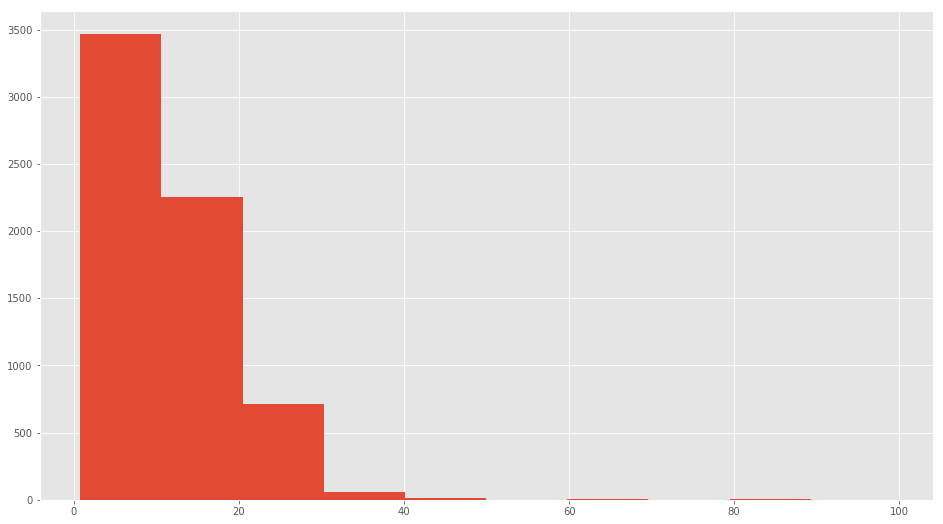

In [322]:
df[filter_df].rolling_gain_std.hist()

In [313]:
df[filter_df2].rolling_gain_std.mean()

18.285982931656498

In [199]:
df[['rolling_gain','test_gain','rolling_gain_std']].corr()

,rolling_gain,test_gain,rolling_gain_std
rolling_gain,1.000000,0.594910,-0.308558
test_gain,0.594910,1.000000,-0.605584
rolling_gain_std,-0.308558,-0.605584,1.000000


In [257]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()
    forecast = pd.read_feather(PROPHET_PATH+YVERSION+page+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [338]:
for row in df[filter_df2].sort_values(
    by='test_gain', ascending=True).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))

In [337]:
for row in df[filter_df2].sort_values(
    by='test_gain', ascending=False).iloc[:0].iterrows():
    print(row[1])
    load_plot(str(int(row[1][0])))